# 🖼️ Wikipedia Image Captioning using BLIP

This project extracts images from a given Wikipedia page and generates human-like captions using the [BLIP (Bootstrapped Language-Image Pretraining)](https://huggingface.co/Salesforce/blip-image-captioning-base) model by Salesforce.

## 🚀 Features

- Scrapes all images from a Wikipedia page.
- Filters out non-relevant image types (e.g., SVG, PNG, GIF).
- Uses Hugging Face's BLIP model to generate natural language captions.
- Saves captions with image URLs into a `captions.txt` file.
- Prints each captioned image to the console.

## 🧠 Model Used

- **BLIP Image Captioning (Base)**  
  Model: [`Salesforce/blip-image-captioning-base`](https://huggingface.co/Salesforce/blip-image-captioning-base)

## 📦 Requirements

Install the dependencies using pip:

```bash
pip install transformers pillow beautifulsoup4 requests


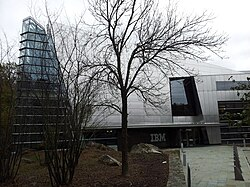

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/IBM_CHQ_-_Oct_2014.jpg/250px-IBM_CHQ_-_Oct_2014.jpg
📜 Caption   : the image of a building



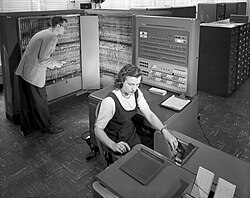

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/IBM_Electronic_Data_Processing_Machine_-_GPN-2000-001881.jpg/250px-IBM_Electronic_Data_Processing_Machine_-_GPN-2000-001881.jpg
📜 Caption   : the image of a man working in a computer lab



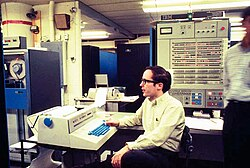

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/IBM360-67AtUmichWithMikeAlexander.jpg/250px-IBM360-67AtUmichWithMikeAlexander.jpg
📜 Caption   : the image of a man sitting in a chair



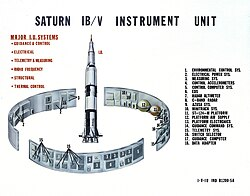

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Saturn_IB_and_V_Instrument_Unit.jpg/250px-Saturn_IB_and_V_Instrument_Unit.jpg
📜 Caption   : the image of a space shuttle is shown in the text



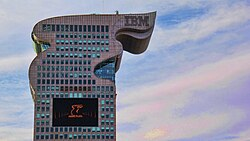

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/IBM_Beijing%2C_Pangu_Plaza.jpg/250px-IBM_Beijing%2C_Pangu_Plaza.jpg
📜 Caption   : the image of a building with a large tower



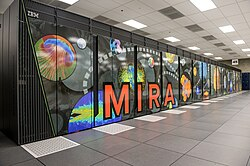

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/Mira_-_Blue_Gene_Q_at_Argonne_National_Laboratory_-_Skin.jpg/250px-Mira_-_Blue_Gene_Q_at_Argonne_National_Laboratory_-_Skin.jpg
📜 Caption   : the image of a large room with a large mural



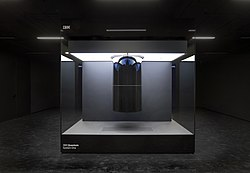

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/IBM_Q_system_%28Fraunhofer_2%29.jpg/250px-IBM_Q_system_%28Fraunhofer_2%29.jpg
📜 Caption   : the image of a room with a black floor



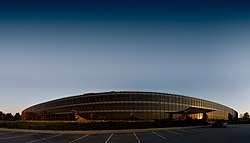

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/IBM_Yorktown_Heights.jpg/250px-IBM_Yorktown_Heights.jpg
📜 Caption   : the image of a stadium



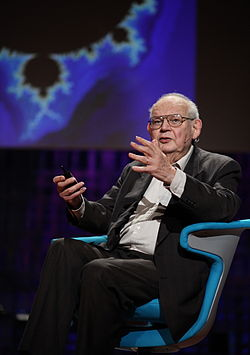

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Benoit_Mandelbrot%2C_TED_2010.jpg/250px-Benoit_Mandelbrot%2C_TED_2010.jpg
📜 Caption   : the image of a man sitting in a chair



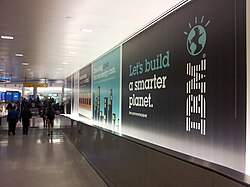

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/IBM_ads_at_JFK.jpg/250px-IBM_ads_at_JFK.jpg
📜 Caption   : the image of a large airport



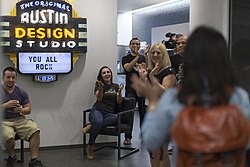

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Ibmaustin_designcamp.jpg/250px-Ibmaustin_designcamp.jpg
📜 Caption   : the image of a group of people sitting in a room



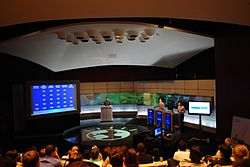

🖼️  Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Watson_Jeopardy_demo.jpg/250px-Watson_Jeopardy_demo.jpg
📜 Caption   : the image of a group of people in a room

⛔ Skipping small image: https://en.wikipedia.org/wiki/Special:CentralAutoLogin/start?type=1x1&usesul3=1 (1x1)


In [13]:
import requests
from PIL import Image
from transformers import AutoProcessor, BlipForConditionalGeneration
from bs4 import BeautifulSoup
from io import BytesIO
from IPython.display import display

# -------------------------------------------------------
# 1. Load BLIP model and processor
# -------------------------------------------------------
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# -------------------------------------------------------
# 2. Define the target URL to extract images from
# -------------------------------------------------------
page_url = "https://en.wikipedia.org/wiki/IBM"
response = requests.get(page_url)

# -------------------------------------------------------
# 3. Parse the HTML content using BeautifulSoup
# -------------------------------------------------------
soup = BeautifulSoup(response.text, 'html.parser')

# -------------------------------------------------------
# 4. Find all image (<img>) tags in the page
# -------------------------------------------------------
images = soup.find_all('img')

# -------------------------------------------------------
# 5. Open a file to store image captions
# -------------------------------------------------------
with open("captions.txt", "w", encoding="utf-8") as caption_file:
    for img in images:
        img_url = img.get('src')

        # -------------------------------------------------------
        # 6. Filter out unwanted image types (SVG, PNG, GIF)
        # -------------------------------------------------------
        if not img_url or img_url.endswith(('.svg', '.png', '.gif')):
            continue

        # -------------------------------------------------------
        # 7. Make image URL absolute if it's relative
        # -------------------------------------------------------
        if img_url.startswith('//'):
            img_url = 'https:' + img_url
        elif img_url.startswith('/'):
            img_url = 'https://en.wikipedia.org' + img_url
        elif not img_url.startswith('http'):
            continue  # skip invalid URLs

        try:
            # -------------------------------------------------------
            # 8. Load and preprocess the image
            # -------------------------------------------------------
            image_response = requests.get(img_url, timeout=5)
            image = Image.open(BytesIO(image_response.content)).convert("RGB")

             # ✅ Skip very small images (e.g. 1x1 tracking pixels)
            if image.width < 50 or image.height < 50:
                print(f"⛔ Skipping small image: {img_url} ({image.width}x{image.height})")
                continue

            # -------------------------------------------------------
            # 9. Generate caption using BLIP model
            # -------------------------------------------------------
            inputs = processor(images=image, text="the image of", return_tensors="pt")
            output = model.generate(
                pixel_values=inputs["pixel_values"],
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=50
            )
            caption = processor.decode(output[0], skip_special_tokens=True)

            # -------------------------------------------------------
            # 10. Write caption to file and print to console
            # -------------------------------------------------------
            caption_file.write(f"Image URL: {img_url}\nCaption: {caption}\n\n")
            display(image)
            print(f"🖼️  Image URL: {img_url}")
            print(f"📜 Caption   : {caption}\n")

        except Exception as e:
            print(f"⚠️  Error processing image {img_url}: {e}")
            continue
